**Mount to Google Drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Import Necessary Libraries**

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary
import numpy as np
import json
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from tqdm import tqdm
import time
import seaborn as sns
import shutil

1. Load Preprocessed Tensors

In [ ]:
X_train_tensor = torch.load('/content/drive/MyDrive/Thesis - Undergraduate Ch./Preprocessing/X_train_7000_tensor_most.pt')
X_test_tensor = torch.load('/content/drive/MyDrive/Thesis - Undergraduate Ch./Preprocessing/X_test_1500_tensor_most.pt')
y_test_tensor = torch.load('/content/drive/MyDrive/Thesis - Undergraduate Ch./Preprocessing/y_test_1500_tensor_most.pt')

print("Preprocessed tensors loaded successfully!")

<ipython-input-3-5fc4154c7302>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  X_train_tensor = torch.load('/content/drive/MyDrive/Thesis - Undergraduate Ch./Preprocessing/

Preprocessed tensors loaded successfully!


In [ ]:
# Print the output shape for each data
print(f"X_train shape: {X_train_tensor.shape}")
print(f"X_test shape: {X_test_tensor.shape}")
print(f"y_test shape: {y_test_tensor.shape}")

X_train shape: torch.Size([7000, 1, 100, 87])
X_test shape: torch.Size([3000, 1, 100, 87])
y_test shape: torch.Size([3000])


2. Define VAE-CNN Architecture

In [ ]:
#@title Vocabulary = 87 (Dataset 10000: 7000 Legitimate & 1500 Legitimate + 1500 Phishing)
class VAE_CNN(nn.Module):
    def __init__(self, latent_dim=4):
        super(VAE_CNN, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        # Output size (CNN)
        self.flattened_size = 128 * 12 * 10 

        self.fc_mu = nn.Linear(self.flattened_size, latent_dim)
        self.fc_logvar = nn.Linear(self.flattened_size, latent_dim)
        self.fc_decode = nn.Linear(latent_dim, self.flattened_size)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # [64,24,20]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),   # [32,48,40]
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=(5,8), stride=2, padding=0, output_padding=(1,1)),  # [1,100,87]
        )

    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
      x = self.fc_decode(z)
      x = x.view(-1, 128, 12, 10)
      x = self.decoder(x)
      return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

# Display a summary of the model architecture
model = VAE_CNN()
summary(model, input_size=[(1, 100, 87)], batch_size=1) # (batch, channels, height, width = N, C, H, W)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 32, 50, 43]             544
       BatchNorm2d-2            [1, 32, 50, 43]              64
              ReLU-3            [1, 32, 50, 43]               0
            Conv2d-4            [1, 64, 25, 21]          32,832
       BatchNorm2d-5            [1, 64, 25, 21]             128
              ReLU-6            [1, 64, 25, 21]               0
            Conv2d-7           [1, 128, 12, 10]         131,200
       BatchNorm2d-8           [1, 128, 12, 10]             256
              ReLU-9           [1, 128, 12, 10]               0
           Linear-10                     [1, 4]          61,444
           Linear-11                     [1, 4]          61,444
           Linear-12                 [1, 15360]          76,800
  ConvTranspose2d-13            [1, 64, 24, 20]         131,136
      BatchNorm2d-14            [1, 64,

4. Train Model


[Training] latent_dim: 4, lr: 0.001, batch_size: 16, optimizer: Adam


Training 4, lr 0.001, bs 16, opt Adam:   5%|▌         | 1/20 [02:18<43:47, 138.31s/it]

Epoch [1/20] - kl: 9.1458 - loss: 73.4539 - recon: 64.3081


Training 4, lr 0.001, bs 16, opt Adam:  10%|█         | 2/20 [04:33<40:58, 136.59s/it]

Epoch [2/20] - kl: 3.7949 - loss: 37.9447 - recon: 34.1498


Training 4, lr 0.001, bs 16, opt Adam:  15%|█▌        | 3/20 [06:53<39:07, 138.06s/it]

Epoch [3/20] - kl: 2.3575 - loss: 36.1016 - recon: 33.7440


Training 4, lr 0.001, bs 16, opt Adam:  20%|██        | 4/20 [09:08<36:30, 136.91s/it]

Epoch [4/20] - kl: 1.4684 - loss: 34.9618 - recon: 33.4934


Training 4, lr 0.001, bs 16, opt Adam:  25%|██▌       | 5/20 [11:28<34:27, 137.83s/it]

Epoch [5/20] - kl: 0.9121 - loss: 34.2044 - recon: 33.2923


Training 4, lr 0.001, bs 16, opt Adam:  30%|███       | 6/20 [13:48<32:20, 138.63s/it]

Epoch [6/20] - kl: 0.5290 - loss: 33.6542 - recon: 33.1252


Training 4, lr 0.001, bs 16, opt Adam:  35%|███▌      | 7/20 [16:10<30:16, 139.74s/it]

Epoch [7/20] - kl: 0.2461 - loss: 33.2396 - recon: 32.9934


Training 4, lr 0.001, bs 16, opt Adam:  40%|████      | 8/20 [18:29<27:53, 139.46s/it]

Epoch [8/20] - kl: 0.1078 - loss: 32.9201 - recon: 32.8123


Training 4, lr 0.001, bs 16, opt Adam:  45%|████▌     | 9/20 [20:46<25:28, 138.92s/it]

Epoch [9/20] - kl: 0.0391 - loss: 32.7230 - recon: 32.6840


Training 4, lr 0.001, bs 16, opt Adam:  50%|█████     | 10/20 [23:02<22:58, 137.87s/it]

Epoch [10/20] - kl: 0.0141 - loss: 32.5926 - recon: 32.5784


Training 4, lr 0.001, bs 16, opt Adam:  55%|█████▌    | 11/20 [25:18<20:34, 137.17s/it]

Epoch [11/20] - kl: 0.0060 - loss: 32.5320 - recon: 32.5259


Training 4, lr 0.001, bs 16, opt Adam:  60%|██████    | 12/20 [27:35<18:18, 137.37s/it]

Epoch [12/20] - kl: 0.0035 - loss: 32.5051 - recon: 32.5016


Training 4, lr 0.001, bs 16, opt Adam:  65%|██████▌   | 13/20 [29:53<16:01, 137.43s/it]

Epoch [13/20] - kl: 0.0021 - loss: 32.4626 - recon: 32.4605


Training 4, lr 0.001, bs 16, opt Adam:  70%|███████   | 14/20 [32:10<13:44, 137.47s/it]

Epoch [14/20] - kl: 0.0014 - loss: 32.4463 - recon: 32.4449


Training 4, lr 0.001, bs 16, opt Adam:  75%|███████▌  | 15/20 [34:27<11:26, 137.22s/it]

Epoch [15/20] - kl: 0.0012 - loss: 32.4458 - recon: 32.4446


Training 4, lr 0.001, bs 16, opt Adam:  80%|████████  | 16/20 [36:44<09:07, 136.98s/it]

Epoch [16/20] - kl: 0.0010 - loss: 32.4190 - recon: 32.4181


Training 4, lr 0.001, bs 16, opt Adam:  85%|████████▌ | 17/20 [39:01<06:51, 137.25s/it]

Epoch [17/20] - kl: 0.0008 - loss: 32.4110 - recon: 32.4103


Training 4, lr 0.001, bs 16, opt Adam:  90%|█████████ | 18/20 [41:20<04:35, 137.53s/it]

Epoch [18/20] - kl: 0.0006 - loss: 32.3992 - recon: 32.3986


Training 4, lr 0.001, bs 16, opt Adam:  95%|█████████▌| 19/20 [43:36<02:17, 137.31s/it]

Epoch [19/20] - kl: 0.0005 - loss: 32.4000 - recon: 32.3995


Training 4, lr 0.001, bs 16, opt Adam: 100%|██████████| 20/20 [45:55<00:00, 137.79s/it]


Epoch [20/20] - kl: 0.0004 - loss: 32.3827 - recon: 32.3824
Training duration: 45.93 minutes


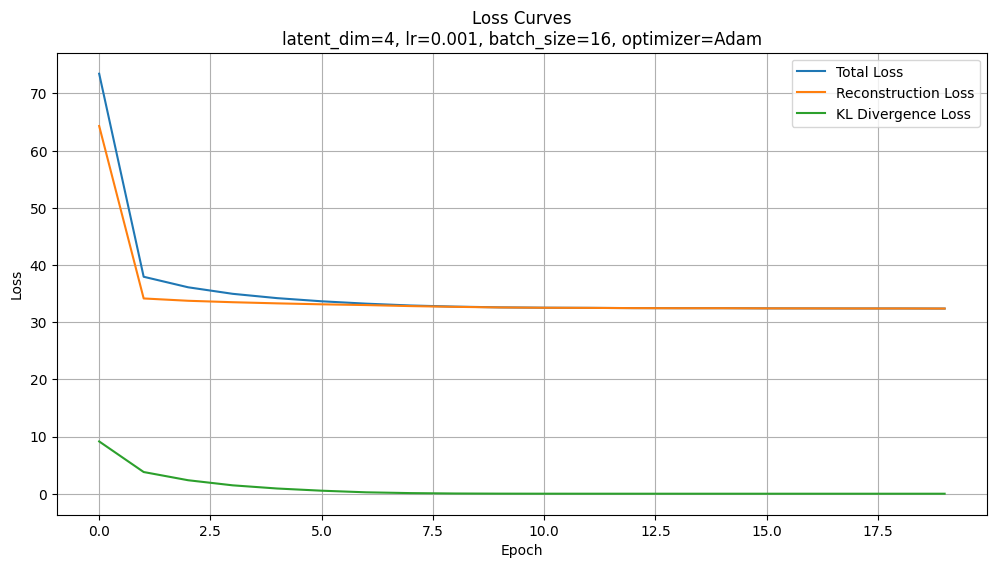

Plot saved: /content/drive/MyDrive/Thesis - Undergraduate Ch./Models/Dataset 10000/Plots/Fixed/loss_latent4_lr0.001_bs16_optAdam.png
Model trained and saved successfully at: /content/drive/MyDrive/Thesis - Undergraduate Ch./Models/Dataset 10000/Training Results/Fixed/vae_cnn_latent4_lr0.001_bs16_optAdam.pth

[Training] latent_dim: 4, lr: 0.001, batch_size: 32, optimizer: Adam


Training 4, lr 0.001, bs 32, opt Adam:   5%|▌         | 1/20 [02:16<43:17, 136.73s/it]

Epoch [1/20] - kl: 11.8490 - loss: 126.9941 - recon: 115.1451


Training 4, lr 0.001, bs 32, opt Adam:  10%|█         | 2/20 [04:29<40:20, 134.47s/it]

Epoch [2/20] - kl: 6.3420 - loss: 41.2987 - recon: 34.9567


Training 4, lr 0.001, bs 32, opt Adam:  15%|█▌        | 3/20 [06:45<38:16, 135.10s/it]

Epoch [3/20] - kl: 4.6225 - loss: 38.8033 - recon: 34.1808


Training 4, lr 0.001, bs 32, opt Adam:  20%|██        | 4/20 [09:00<36:02, 135.16s/it]

Epoch [4/20] - kl: 3.6121 - loss: 37.4588 - recon: 33.8467


Training 4, lr 0.001, bs 32, opt Adam:  25%|██▌       | 5/20 [11:23<34:29, 137.95s/it]

Epoch [5/20] - kl: 2.9358 - loss: 36.5545 - recon: 33.6186


Training 4, lr 0.001, bs 32, opt Adam:  30%|███       | 6/20 [13:40<32:07, 137.67s/it]

Epoch [6/20] - kl: 2.3820 - loss: 35.8664 - recon: 33.4843


Training 4, lr 0.001, bs 32, opt Adam:  35%|███▌      | 7/20 [15:57<29:47, 137.48s/it]

Epoch [7/20] - kl: 1.9469 - loss: 35.2971 - recon: 33.3502


Training 4, lr 0.001, bs 32, opt Adam:  40%|████      | 8/20 [18:13<27:22, 136.85s/it]

Epoch [8/20] - kl: 1.5869 - loss: 34.8943 - recon: 33.3075


Training 4, lr 0.001, bs 32, opt Adam:  45%|████▌     | 9/20 [20:29<25:04, 136.75s/it]

Epoch [9/20] - kl: 1.2338 - loss: 34.4516 - recon: 33.2177


Training 4, lr 0.001, bs 32, opt Adam:  50%|█████     | 10/20 [22:45<22:43, 136.36s/it]

Epoch [10/20] - kl: 1.0049 - loss: 34.1623 - recon: 33.1574


Training 4, lr 0.001, bs 32, opt Adam:  55%|█████▌    | 11/20 [24:59<20:22, 135.81s/it]

Epoch [11/20] - kl: 0.7858 - loss: 33.9331 - recon: 33.1473


Training 4, lr 0.001, bs 32, opt Adam:  60%|██████    | 12/20 [27:14<18:03, 135.47s/it]

Epoch [12/20] - kl: 0.5688 - loss: 33.6465 - recon: 33.0777


Training 4, lr 0.001, bs 32, opt Adam:  65%|██████▌   | 13/20 [29:30<15:49, 135.64s/it]

Epoch [13/20] - kl: 0.4336 - loss: 33.4133 - recon: 32.9797


Training 4, lr 0.001, bs 32, opt Adam:  70%|███████   | 14/20 [31:44<13:30, 135.08s/it]

Epoch [14/20] - kl: 0.3115 - loss: 33.3261 - recon: 33.0146


Training 4, lr 0.001, bs 32, opt Adam:  75%|███████▌  | 15/20 [34:00<11:16, 135.39s/it]

Epoch [15/20] - kl: 0.1977 - loss: 33.0956 - recon: 32.8979


Training 4, lr 0.001, bs 32, opt Adam:  80%|████████  | 16/20 [36:17<09:03, 135.84s/it]

Epoch [16/20] - kl: 0.1203 - loss: 32.8914 - recon: 32.7712


Training 4, lr 0.001, bs 32, opt Adam:  85%|████████▌ | 17/20 [38:34<06:48, 136.17s/it]

Epoch [17/20] - kl: 0.0755 - loss: 32.7898 - recon: 32.7143


Training 4, lr 0.001, bs 32, opt Adam:  90%|█████████ | 18/20 [40:51<04:32, 136.33s/it]

Epoch [18/20] - kl: 0.0456 - loss: 32.7171 - recon: 32.6715


Training 4, lr 0.001, bs 32, opt Adam:  95%|█████████▌| 19/20 [43:07<02:16, 136.43s/it]

Epoch [19/20] - kl: 0.0322 - loss: 32.6331 - recon: 32.6009


Training 4, lr 0.001, bs 32, opt Adam: 100%|██████████| 20/20 [45:22<00:00, 136.10s/it]


Epoch [20/20] - kl: 0.0199 - loss: 32.5887 - recon: 32.5688
Training duration: 45.37 minutes


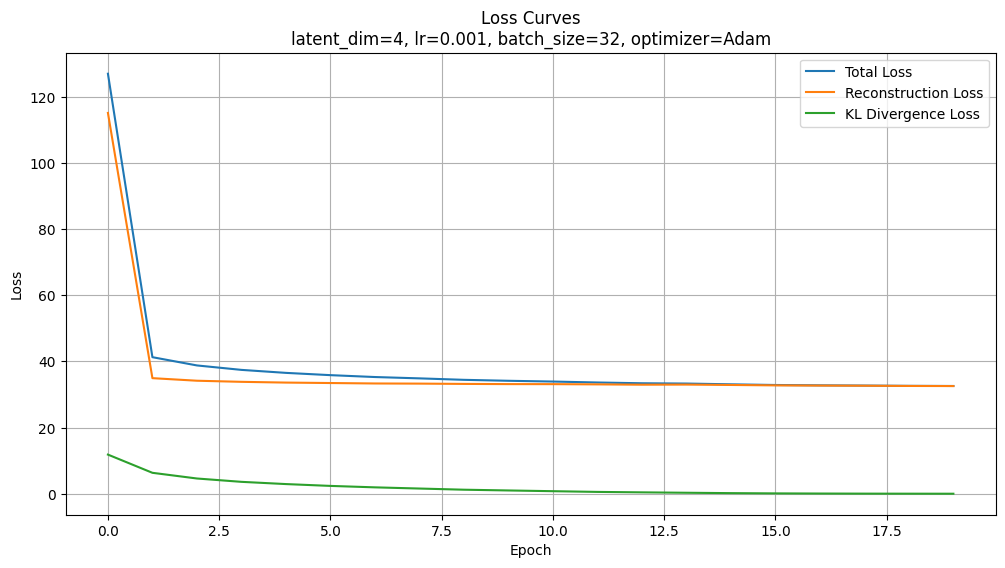

Plot saved: /content/drive/MyDrive/Thesis - Undergraduate Ch./Models/Dataset 10000/Plots/Fixed/loss_latent4_lr0.001_bs32_optAdam.png
Model trained and saved successfully at: /content/drive/MyDrive/Thesis - Undergraduate Ch./Models/Dataset 10000/Training Results/Fixed/vae_cnn_latent4_lr0.001_bs32_optAdam.pth

[Training] latent_dim: 8, lr: 0.001, batch_size: 16, optimizer: Adam


Training 8, lr 0.001, bs 16, opt Adam:   5%|▌         | 1/20 [02:14<42:37, 134.58s/it]

Epoch [1/20] - kl: 16.2332 - loss: 128.2487 - recon: 112.0155


Training 8, lr 0.001, bs 16, opt Adam:  10%|█         | 2/20 [04:30<40:32, 135.12s/it]

Epoch [2/20] - kl: 4.9948 - loss: 40.2832 - recon: 35.2884


Training 8, lr 0.001, bs 16, opt Adam:  15%|█▌        | 3/20 [06:45<38:17, 135.16s/it]

Epoch [3/20] - kl: 2.6509 - loss: 36.8513 - recon: 34.2004


Training 8, lr 0.001, bs 16, opt Adam:  20%|██        | 4/20 [09:00<36:06, 135.38s/it]

Epoch [4/20] - kl: 1.6548 - loss: 35.3617 - recon: 33.7068


Training 8, lr 0.001, bs 16, opt Adam:  25%|██▌       | 5/20 [11:17<33:55, 135.70s/it]

Epoch [5/20] - kl: 0.8567 - loss: 34.1860 - recon: 33.3293


Training 8, lr 0.001, bs 16, opt Adam:  30%|███       | 6/20 [13:31<31:31, 135.13s/it]

Epoch [6/20] - kl: 0.4312 - loss: 33.5106 - recon: 33.0793


Training 8, lr 0.001, bs 16, opt Adam:  35%|███▌      | 7/20 [15:47<29:21, 135.51s/it]

Epoch [7/20] - kl: 0.1875 - loss: 33.0542 - recon: 32.8668


Training 8, lr 0.001, bs 16, opt Adam:  40%|████      | 8/20 [18:03<27:08, 135.73s/it]

Epoch [8/20] - kl: 0.0672 - loss: 32.7493 - recon: 32.6821


Training 8, lr 0.001, bs 16, opt Adam:  45%|████▌     | 9/20 [20:18<24:50, 135.52s/it]

Epoch [9/20] - kl: 0.0272 - loss: 32.6275 - recon: 32.6003


Training 8, lr 0.001, bs 16, opt Adam:  50%|█████     | 10/20 [22:33<22:34, 135.40s/it]

Epoch [10/20] - kl: 0.0106 - loss: 32.5439 - recon: 32.5333


Training 8, lr 0.001, bs 16, opt Adam:  55%|█████▌    | 11/20 [24:49<20:20, 135.58s/it]

Epoch [11/20] - kl: 0.0055 - loss: 32.5063 - recon: 32.5008


Training 8, lr 0.001, bs 16, opt Adam:  60%|██████    | 12/20 [27:04<18:01, 135.17s/it]

Epoch [12/20] - kl: 0.0032 - loss: 32.4684 - recon: 32.4652


Training 8, lr 0.001, bs 16, opt Adam:  65%|██████▌   | 13/20 [29:19<15:47, 135.29s/it]

Epoch [13/20] - kl: 0.0025 - loss: 32.4452 - recon: 32.4427


Training 8, lr 0.001, bs 16, opt Adam:  70%|███████   | 14/20 [31:35<13:32, 135.37s/it]

Epoch [14/20] - kl: 0.0018 - loss: 32.4352 - recon: 32.4334


Training 8, lr 0.001, bs 16, opt Adam:  75%|███████▌  | 15/20 [33:51<11:17, 135.47s/it]

Epoch [15/20] - kl: 0.0012 - loss: 32.4342 - recon: 32.4330


Training 8, lr 0.001, bs 16, opt Adam:  80%|████████  | 16/20 [36:08<09:04, 136.09s/it]

Epoch [16/20] - kl: 0.0009 - loss: 32.4186 - recon: 32.4177


Training 8, lr 0.001, bs 16, opt Adam:  85%|████████▌ | 17/20 [38:24<06:48, 136.15s/it]

Epoch [17/20] - kl: 0.0008 - loss: 32.4302 - recon: 32.4294


Training 8, lr 0.001, bs 16, opt Adam:  90%|█████████ | 18/20 [40:40<04:31, 135.88s/it]

Epoch [18/20] - kl: 0.0008 - loss: 32.3960 - recon: 32.3952


Training 8, lr 0.001, bs 16, opt Adam:  95%|█████████▌| 19/20 [42:55<02:15, 135.76s/it]

Epoch [19/20] - kl: 0.0008 - loss: 32.3975 - recon: 32.3967


Training 8, lr 0.001, bs 16, opt Adam: 100%|██████████| 20/20 [45:11<00:00, 135.56s/it]


Epoch [20/20] - kl: 0.0006 - loss: 32.3957 - recon: 32.3951
Training duration: 45.19 minutes


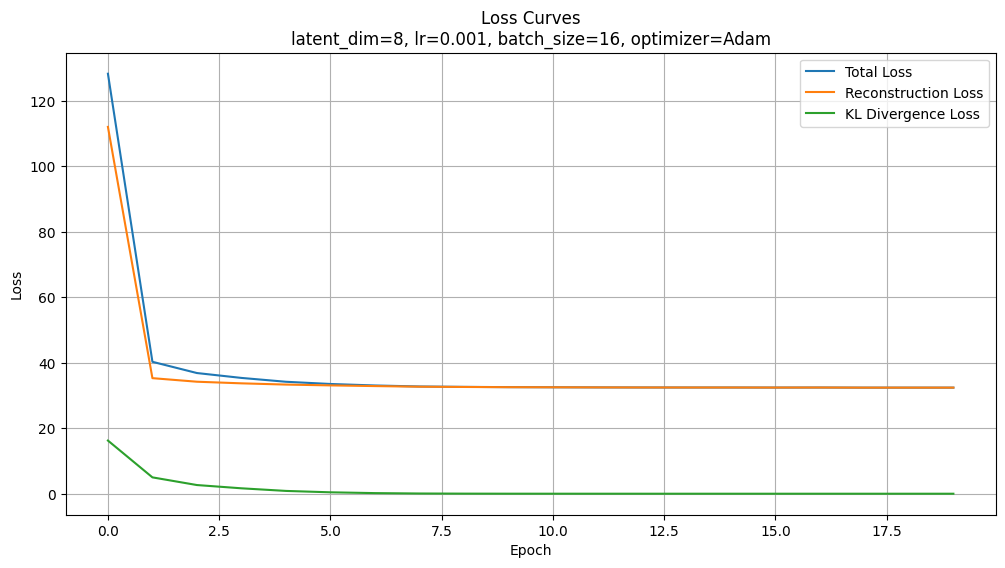

Plot saved: /content/drive/MyDrive/Thesis - Undergraduate Ch./Models/Dataset 10000/Plots/Fixed/loss_latent8_lr0.001_bs16_optAdam.png
Model trained and saved successfully at: /content/drive/MyDrive/Thesis - Undergraduate Ch./Models/Dataset 10000/Training Results/Fixed/vae_cnn_latent8_lr0.001_bs16_optAdam.pth

[Training] latent_dim: 8, lr: 0.001, batch_size: 32, optimizer: Adam


Training 8, lr 0.001, bs 32, opt Adam:   5%|▌         | 1/20 [02:15<42:51, 135.37s/it]

Epoch [1/20] - kl: 20.6250 - loss: 190.1069 - recon: 169.4819


Training 8, lr 0.001, bs 32, opt Adam:  10%|█         | 2/20 [04:31<40:39, 135.55s/it]

Epoch [2/20] - kl: 9.5202 - loss: 46.4402 - recon: 36.9200


Training 8, lr 0.001, bs 32, opt Adam:  15%|█▌        | 3/20 [06:46<38:26, 135.70s/it]

Epoch [3/20] - kl: 6.5230 - loss: 42.1500 - recon: 35.6270


Training 8, lr 0.001, bs 32, opt Adam:  20%|██        | 4/20 [09:01<36:01, 135.08s/it]

Epoch [4/20] - kl: 4.8485 - loss: 39.8284 - recon: 34.9799


Training 8, lr 0.001, bs 32, opt Adam:  25%|██▌       | 5/20 [11:14<33:39, 134.63s/it]

Epoch [5/20] - kl: 3.6854 - loss: 38.2157 - recon: 34.5304


Training 8, lr 0.001, bs 32, opt Adam:  30%|███       | 6/20 [13:27<31:15, 133.96s/it]

Epoch [6/20] - kl: 2.9087 - loss: 37.1271 - recon: 34.2184


Training 8, lr 0.001, bs 32, opt Adam:  35%|███▌      | 7/20 [15:40<28:55, 133.53s/it]

Epoch [7/20] - kl: 2.2954 - loss: 36.2846 - recon: 33.9893


Training 8, lr 0.001, bs 32, opt Adam:  40%|████      | 8/20 [17:51<26:32, 132.69s/it]

Epoch [8/20] - kl: 1.7994 - loss: 35.5721 - recon: 33.7727


Training 8, lr 0.001, bs 32, opt Adam:  45%|████▌     | 9/20 [20:04<24:23, 133.05s/it]

Epoch [9/20] - kl: 1.3937 - loss: 34.9860 - recon: 33.5923


Training 8, lr 0.001, bs 32, opt Adam:  50%|█████     | 10/20 [22:16<22:05, 132.50s/it]

Epoch [10/20] - kl: 1.0866 - loss: 34.5545 - recon: 33.4679


Training 8, lr 0.001, bs 32, opt Adam:  55%|█████▌    | 11/20 [24:28<19:51, 132.43s/it]

Epoch [11/20] - kl: 0.7864 - loss: 34.0984 - recon: 33.3119


Training 8, lr 0.001, bs 32, opt Adam:  60%|██████    | 12/20 [26:39<17:35, 131.99s/it]

Epoch [12/20] - kl: 0.5626 - loss: 33.7492 - recon: 33.1866


Training 8, lr 0.001, bs 32, opt Adam:  65%|██████▌   | 13/20 [28:50<15:22, 131.83s/it]

Epoch [13/20] - kl: 0.3732 - loss: 33.4314 - recon: 33.0582


Training 8, lr 0.001, bs 32, opt Adam:  70%|███████   | 14/20 [31:02<13:09, 131.64s/it]

Epoch [14/20] - kl: 0.2497 - loss: 33.1943 - recon: 32.9447


Training 8, lr 0.001, bs 32, opt Adam:  75%|███████▌  | 15/20 [33:15<11:00, 132.08s/it]

Epoch [15/20] - kl: 0.1493 - loss: 33.0040 - recon: 32.8547


Training 8, lr 0.001, bs 32, opt Adam:  80%|████████  | 16/20 [35:29<08:50, 132.74s/it]

Epoch [16/20] - kl: 0.0971 - loss: 32.9084 - recon: 32.8114


Training 8, lr 0.001, bs 32, opt Adam:  85%|████████▌ | 17/20 [37:42<06:38, 132.68s/it]

Epoch [17/20] - kl: 0.0566 - loss: 32.7467 - recon: 32.6901


Training 8, lr 0.001, bs 32, opt Adam:  90%|█████████ | 18/20 [39:53<04:24, 132.40s/it]

Epoch [18/20] - kl: 0.0303 - loss: 32.6791 - recon: 32.6489


Training 8, lr 0.001, bs 32, opt Adam:  95%|█████████▌| 19/20 [42:06<02:12, 132.54s/it]

Epoch [19/20] - kl: 0.0209 - loss: 32.6392 - recon: 32.6183


Training 8, lr 0.001, bs 32, opt Adam: 100%|██████████| 20/20 [44:16<00:00, 132.82s/it]


Epoch [20/20] - kl: 0.0138 - loss: 32.5782 - recon: 32.5644
Training duration: 44.27 minutes


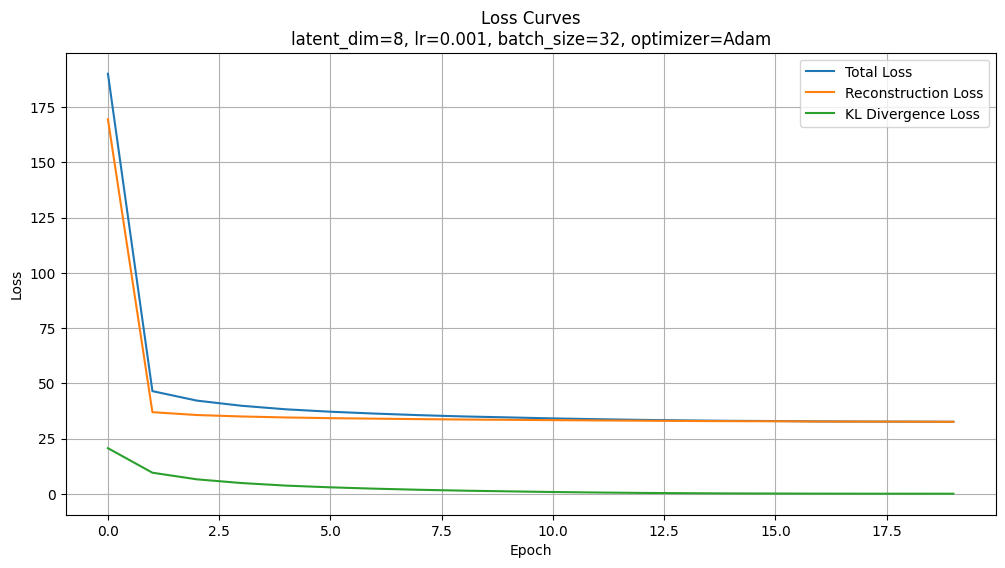

Plot saved: /content/drive/MyDrive/Thesis - Undergraduate Ch./Models/Dataset 10000/Plots/Fixed/loss_latent8_lr0.001_bs32_optAdam.png
Model trained and saved successfully at: /content/drive/MyDrive/Thesis - Undergraduate Ch./Models/Dataset 10000/Training Results/Fixed/vae_cnn_latent8_lr0.001_bs32_optAdam.pth

[Training] latent_dim: 16, lr: 0.001, batch_size: 16, optimizer: Adam


Training 16, lr 0.001, bs 16, opt Adam:   5%|▌         | 1/20 [02:13<42:12, 133.29s/it]

Epoch [1/20] - kl: 17.9306 - loss: 103.4288 - recon: 85.4982


Training 16, lr 0.001, bs 16, opt Adam:  10%|█         | 2/20 [04:25<39:49, 132.76s/it]

Epoch [2/20] - kl: 4.3224 - loss: 40.4165 - recon: 36.0940


Training 16, lr 0.001, bs 16, opt Adam:  15%|█▌        | 3/20 [06:39<37:46, 133.31s/it]

Epoch [3/20] - kl: 2.0220 - loss: 36.5790 - recon: 34.5570


Training 16, lr 0.001, bs 16, opt Adam:  20%|██        | 4/20 [08:52<35:27, 132.98s/it]

Epoch [4/20] - kl: 0.8785 - loss: 34.6476 - recon: 33.7691


Training 16, lr 0.001, bs 16, opt Adam:  25%|██▌       | 5/20 [11:06<33:21, 133.47s/it]

Epoch [5/20] - kl: 0.3043 - loss: 33.5152 - recon: 33.2108


Training 16, lr 0.001, bs 16, opt Adam:  30%|███       | 6/20 [13:16<30:53, 132.36s/it]

Epoch [6/20] - kl: 0.0846 - loss: 32.9305 - recon: 32.8460


Training 16, lr 0.001, bs 16, opt Adam:  35%|███▌      | 7/20 [15:30<28:46, 132.80s/it]

Epoch [7/20] - kl: 0.0281 - loss: 32.6874 - recon: 32.6593


Training 16, lr 0.001, bs 16, opt Adam:  40%|████      | 8/20 [17:40<26:24, 132.03s/it]

Epoch [8/20] - kl: 0.0118 - loss: 32.5725 - recon: 32.5607


Training 16, lr 0.001, bs 16, opt Adam:  45%|████▌     | 9/20 [19:54<24:17, 132.46s/it]

Epoch [9/20] - kl: 0.0077 - loss: 32.5252 - recon: 32.5175


Training 16, lr 0.001, bs 16, opt Adam:  50%|█████     | 10/20 [22:06<22:05, 132.51s/it]

Epoch [10/20] - kl: 0.0051 - loss: 32.5196 - recon: 32.5145


Training 16, lr 0.001, bs 16, opt Adam:  55%|█████▌    | 11/20 [24:21<19:57, 133.07s/it]

Epoch [11/20] - kl: 0.0041 - loss: 32.5005 - recon: 32.4964


Training 16, lr 0.001, bs 16, opt Adam:  60%|██████    | 12/20 [26:33<17:41, 132.73s/it]

Epoch [12/20] - kl: 0.0035 - loss: 32.4961 - recon: 32.4926


Training 16, lr 0.001, bs 16, opt Adam:  65%|██████▌   | 13/20 [28:47<15:32, 133.28s/it]

Epoch [13/20] - kl: 0.0029 - loss: 32.4722 - recon: 32.4692


Training 16, lr 0.001, bs 16, opt Adam:  70%|███████   | 14/20 [31:03<13:23, 133.99s/it]

Epoch [14/20] - kl: 0.0027 - loss: 32.4611 - recon: 32.4584


Training 16, lr 0.001, bs 16, opt Adam:  75%|███████▌  | 15/20 [33:18<11:12, 134.51s/it]

Epoch [15/20] - kl: 0.0025 - loss: 32.4675 - recon: 32.4650


Training 16, lr 0.001, bs 16, opt Adam:  80%|████████  | 16/20 [35:34<08:59, 134.78s/it]

Epoch [16/20] - kl: 0.0024 - loss: 32.4500 - recon: 32.4476


Training 16, lr 0.001, bs 16, opt Adam:  85%|████████▌ | 17/20 [37:50<06:45, 135.04s/it]

Epoch [17/20] - kl: 0.0018 - loss: 32.4371 - recon: 32.4353


Training 16, lr 0.001, bs 16, opt Adam:  90%|█████████ | 18/20 [40:04<04:29, 134.80s/it]

Epoch [18/20] - kl: 0.0020 - loss: 32.4318 - recon: 32.4298


Training 16, lr 0.001, bs 16, opt Adam:  95%|█████████▌| 19/20 [42:20<02:15, 135.23s/it]

Epoch [19/20] - kl: 0.0019 - loss: 32.4253 - recon: 32.4234


Training 16, lr 0.001, bs 16, opt Adam: 100%|██████████| 20/20 [44:37<00:00, 133.85s/it]


Epoch [20/20] - kl: 0.0015 - loss: 32.4264 - recon: 32.4250
Training duration: 44.62 minutes


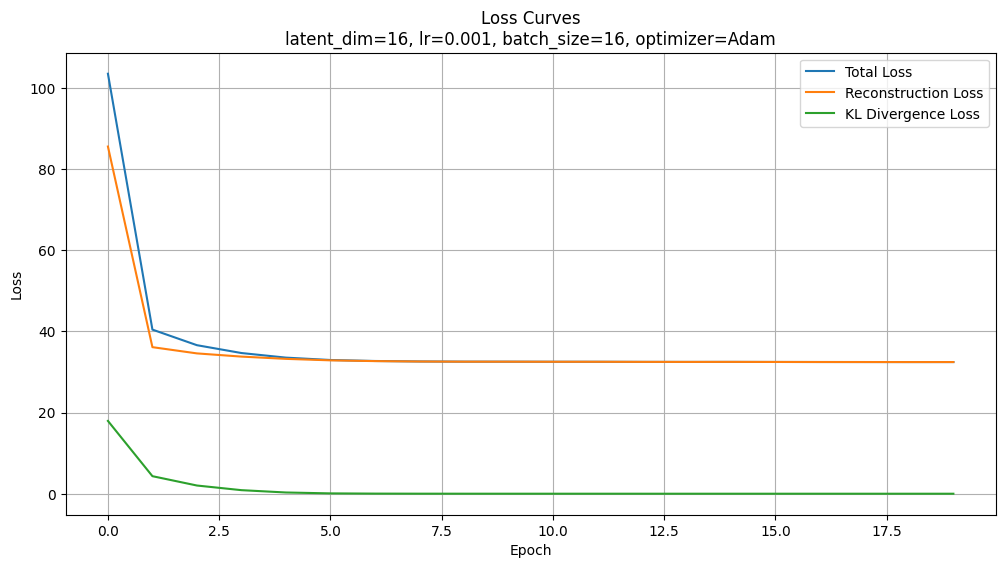

Plot saved: /content/drive/MyDrive/Thesis - Undergraduate Ch./Models/Dataset 10000/Plots/Fixed/loss_latent16_lr0.001_bs16_optAdam.png
Model trained and saved successfully at: /content/drive/MyDrive/Thesis - Undergraduate Ch./Models/Dataset 10000/Training Results/Fixed/vae_cnn_latent16_lr0.001_bs16_optAdam.pth

[Training] latent_dim: 16, lr: 0.001, batch_size: 32, optimizer: Adam


Training 16, lr 0.001, bs 32, opt Adam:   5%|▌         | 1/20 [02:14<42:39, 134.69s/it]

Epoch [1/20] - kl: 26.8742 - loss: 211.4523 - recon: 184.5781


Training 16, lr 0.001, bs 32, opt Adam:  10%|█         | 2/20 [04:30<40:38, 135.48s/it]

Epoch [2/20] - kl: 10.4614 - loss: 49.8179 - recon: 39.3566


Training 16, lr 0.001, bs 32, opt Adam:  15%|█▌        | 3/20 [06:47<38:36, 136.24s/it]

Epoch [3/20] - kl: 6.2311 - loss: 43.2508 - recon: 37.0197


Training 16, lr 0.001, bs 32, opt Adam:  20%|██        | 4/20 [09:02<36:10, 135.66s/it]

Epoch [4/20] - kl: 4.1011 - loss: 39.8735 - recon: 35.7724


Training 16, lr 0.001, bs 32, opt Adam:  25%|██▌       | 5/20 [11:20<34:06, 136.42s/it]

Epoch [5/20] - kl: 2.9975 - loss: 38.0565 - recon: 35.0590


Training 16, lr 0.001, bs 32, opt Adam:  30%|███       | 6/20 [13:37<31:54, 136.74s/it]

Epoch [6/20] - kl: 2.2204 - loss: 36.7678 - recon: 34.5474


Training 16, lr 0.001, bs 32, opt Adam:  35%|███▌      | 7/20 [15:56<29:44, 137.27s/it]

Epoch [7/20] - kl: 1.6287 - loss: 35.7913 - recon: 34.1626


Training 16, lr 0.001, bs 32, opt Adam:  40%|████      | 8/20 [18:11<27:20, 136.67s/it]

Epoch [8/20] - kl: 1.1878 - loss: 35.0587 - recon: 33.8710


Training 16, lr 0.001, bs 32, opt Adam:  45%|████▌     | 9/20 [20:28<25:03, 136.67s/it]

Epoch [9/20] - kl: 0.8071 - loss: 34.3718 - recon: 33.5647


Training 16, lr 0.001, bs 32, opt Adam:  50%|█████     | 10/20 [22:43<22:41, 136.10s/it]

Epoch [10/20] - kl: 0.5449 - loss: 33.8962 - recon: 33.3514


Training 16, lr 0.001, bs 32, opt Adam:  55%|█████▌    | 11/20 [24:57<20:19, 135.46s/it]

Epoch [11/20] - kl: 0.3306 - loss: 33.4596 - recon: 33.1290


Training 16, lr 0.001, bs 32, opt Adam:  60%|██████    | 12/20 [27:10<17:59, 134.96s/it]

Epoch [12/20] - kl: 0.1989 - loss: 33.1749 - recon: 32.9760


Training 16, lr 0.001, bs 32, opt Adam:  65%|██████▌   | 13/20 [29:23<15:39, 134.23s/it]

Epoch [13/20] - kl: 0.1112 - loss: 32.9721 - recon: 32.8609


Training 16, lr 0.001, bs 32, opt Adam:  70%|███████   | 14/20 [31:36<13:22, 133.78s/it]

Epoch [14/20] - kl: 0.0629 - loss: 32.7808 - recon: 32.7179


Training 16, lr 0.001, bs 32, opt Adam:  75%|███████▌  | 15/20 [33:49<11:07, 133.53s/it]

Epoch [15/20] - kl: 0.0396 - loss: 32.6944 - recon: 32.6549


Training 16, lr 0.001, bs 32, opt Adam:  80%|████████  | 16/20 [36:02<08:54, 133.53s/it]

Epoch [16/20] - kl: 0.0256 - loss: 32.6092 - recon: 32.5836


Training 16, lr 0.001, bs 32, opt Adam:  85%|████████▌ | 17/20 [38:11<06:36, 132.25s/it]

Epoch [17/20] - kl: 0.0151 - loss: 32.5463 - recon: 32.5312


Training 16, lr 0.001, bs 32, opt Adam:  90%|█████████ | 18/20 [40:25<04:25, 132.67s/it]

Epoch [18/20] - kl: 0.0117 - loss: 32.5346 - recon: 32.5229


Training 16, lr 0.001, bs 32, opt Adam:  95%|█████████▌| 19/20 [42:39<02:13, 133.04s/it]

Epoch [19/20] - kl: 0.0086 - loss: 32.5030 - recon: 32.4945


Training 16, lr 0.001, bs 32, opt Adam: 100%|██████████| 20/20 [44:54<00:00, 134.73s/it]


Epoch [20/20] - kl: 0.0066 - loss: 32.4720 - recon: 32.4654
Training duration: 44.91 minutes


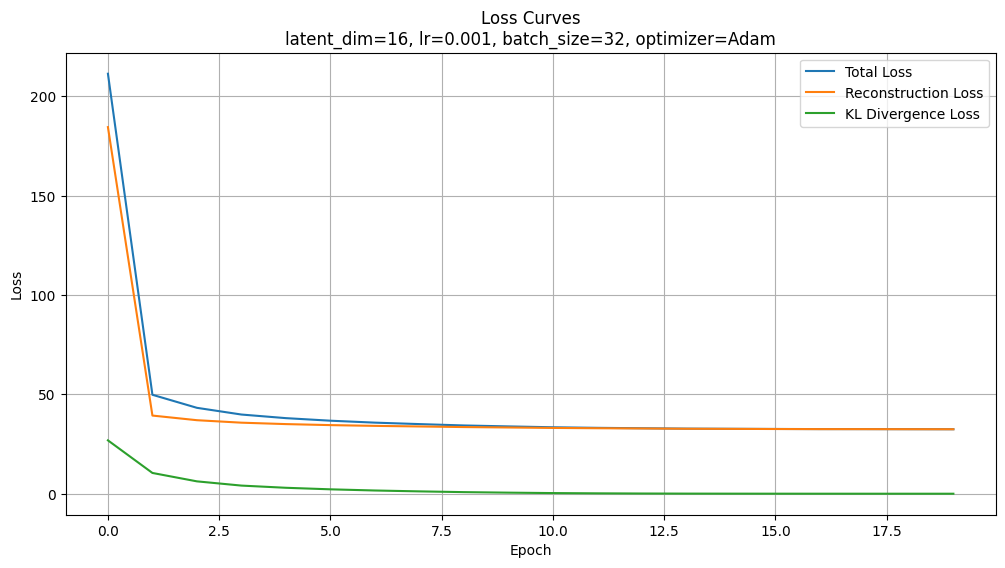

Plot saved: /content/drive/MyDrive/Thesis - Undergraduate Ch./Models/Dataset 10000/Plots/Fixed/loss_latent16_lr0.001_bs32_optAdam.png
Model trained and saved successfully at: /content/drive/MyDrive/Thesis - Undergraduate Ch./Models/Dataset 10000/Training Results/Fixed/vae_cnn_latent16_lr0.001_bs32_optAdam.pth


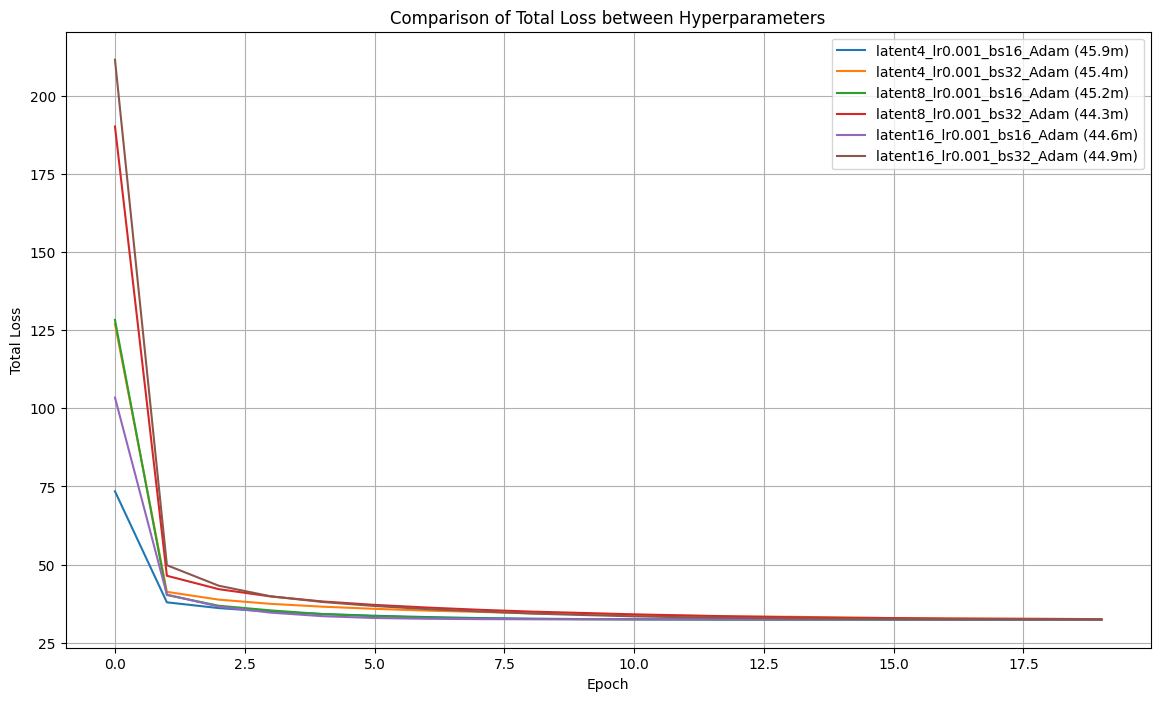

Comparison plot saved: /content/drive/MyDrive/Thesis - Undergraduate Ch./Models/Dataset 10000/Plots/Fixed/comparison_total_loss_updated.png


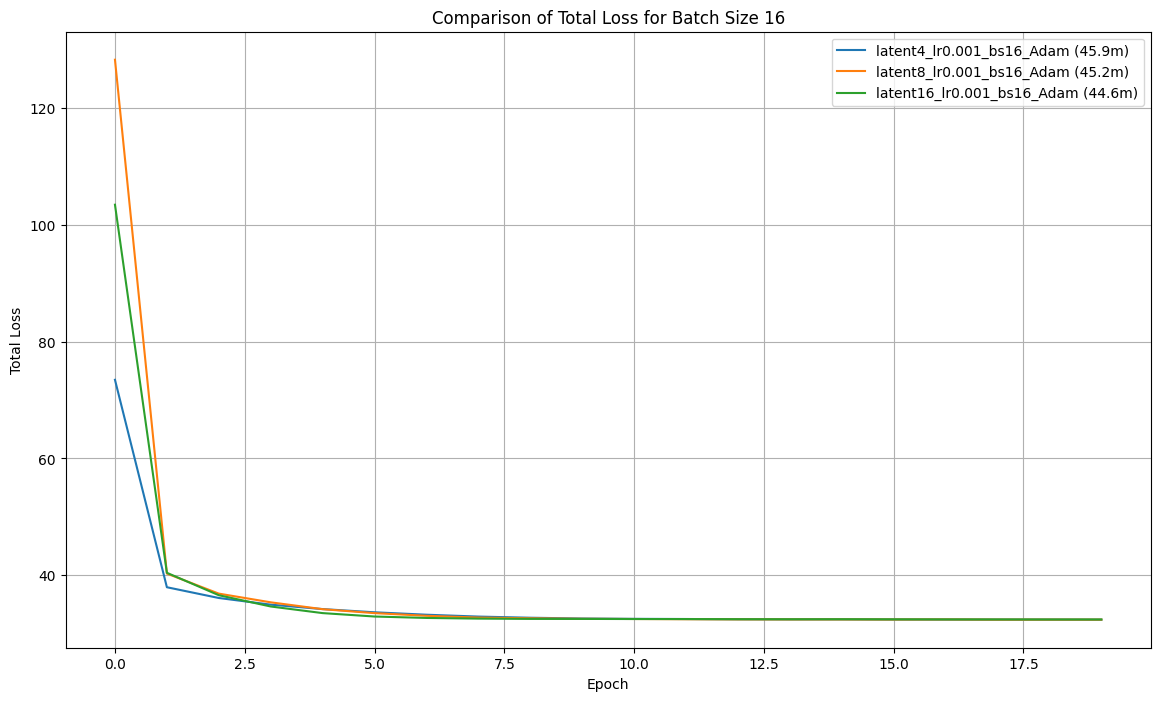

Batch-specific comparison plot saved: /content/drive/MyDrive/Thesis - Undergraduate Ch./Models/Dataset 10000/Plots/Fixed/comparison_total_loss_batch16_updated.png


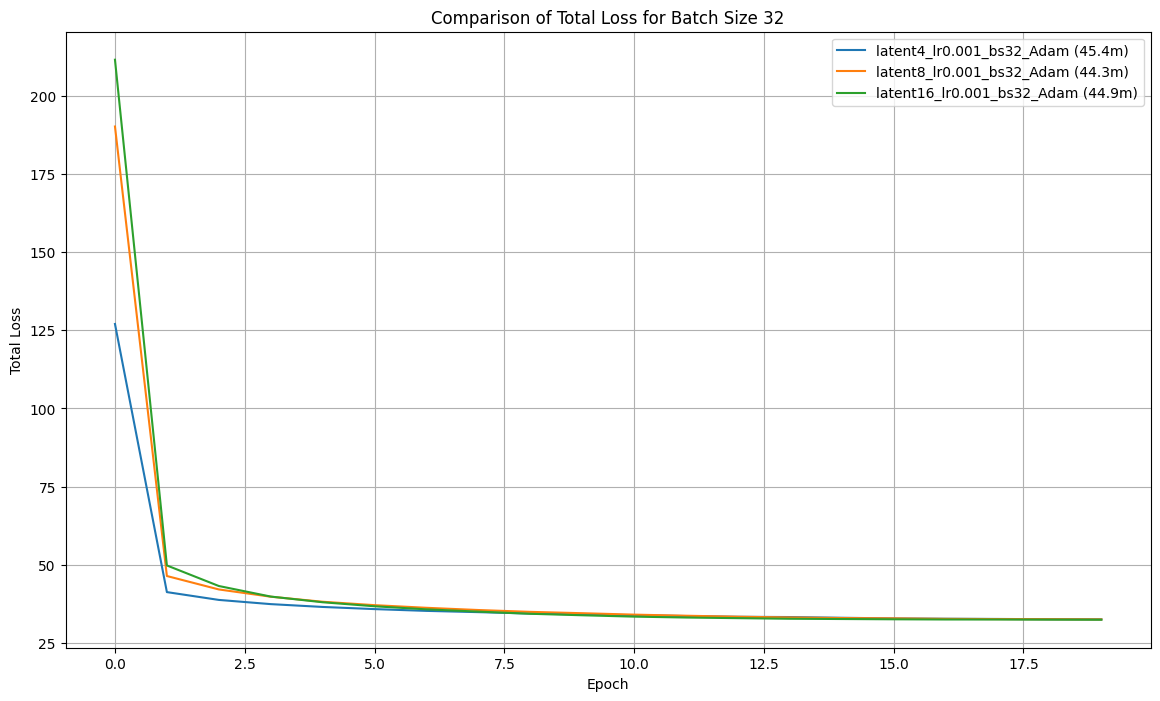

Batch-specific comparison plot saved: /content/drive/MyDrive/Thesis - Undergraduate Ch./Models/Dataset 10000/Plots/Fixed/comparison_total_loss_batch32_updated.png


In [ ]:
#@title With Hyperparameter Tuning (10,000) - Retrained
# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameter candidates
latent_dims = [4, 8, 16]
learning_rates = [0.001]
batch_sizes = [16, 32]
num_epochs = 20
optimizers = ['Adam']

# Loss function
mse_loss = nn.MSELoss(reduction='sum')

# VAE loss function (Reconstruction Loss + KL Divergence Loss)
def vae_loss(recon_x, x, mu, logvar):
    reconstruction_loss = mse_loss(recon_x, x)
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    total_loss = reconstruction_loss + kl_loss
    return total_loss, reconstruction_loss, kl_loss

# Store all training results
results = []

# Loop through each combination of hyperparameters
for latent_dim in latent_dims:
    for lr in learning_rates:
        for batch_size in batch_sizes:
            for opt_name in optimizers:
                print(f"\n[Training] latent_dim: {latent_dim}, lr: {lr}, batch_size: {batch_size}, optimizer: {opt_name}")

                # Create DataLoader for each batch size
                train_loader = DataLoader(TensorDataset(X_train_tensor), batch_size=batch_size, shuffle=True)

                # Initialize model and optimizer
                model = VAE_CNN(latent_dim=latent_dim).to(device)
                optimizer = optim.Adam(model.parameters(), lr=lr)

                train_loss_history = []
                recon_loss_history = []
                kl_loss_history = []

                # Start training timer
                start_time = time.time()

                # Training loop
                for epoch in tqdm(range(num_epochs), desc=f"Training {latent_dim}, lr {lr}, bs {batch_size}, opt {opt_name}"):
                    model.train()
                    total_loss, total_recon_loss, total_kl_loss = 0, 0, 0

                    for batch in train_loader:
                        x_batch = batch[0].to(device)

                        optimizer.zero_grad()
                        recon_batch, mu, logvar = model(x_batch)
                        loss, recon_loss, kl = vae_loss(recon_batch, x_batch, mu, logvar)
                        loss.backward()
                        optimizer.step()

                        total_loss += loss.item()
                        total_recon_loss += recon_loss.item()
                        total_kl_loss += kl.item()

                    avg_loss = total_loss / len(train_loader.dataset)
                    avg_recon_loss = total_recon_loss / len(train_loader.dataset)
                    avg_kl_loss = total_kl_loss / len(train_loader.dataset)

                    train_loss_history.append(avg_loss)
                    recon_loss_history.append(avg_recon_loss)
                    kl_loss_history.append(avg_kl_loss)

                    tqdm.write(f"Epoch [{epoch+1}/{num_epochs}] - kl: {avg_kl_loss:.4f} - loss: {avg_loss:.4f} - recon: {avg_recon_loss:.4f}")

                # End training timer
                end_time = time.time()
                duration = end_time - start_time
                print(f"Training duration: {duration/60:.2f} minutes")

                # Save results
                results.append({
                    'latent_dim': latent_dim,
                    'batch_size': batch_size,
                    'optimizer': opt_name,
                    'learning_rate': lr,
                    'label': f'latent{latent_dim}_lr{lr}_bs{batch_size}_{opt_name}',
                    'train_loss_history': train_loss_history,
                    'duration': duration
                })

                # Plot individual loss curves
                plt.figure(figsize=(12,6))
                plt.plot(train_loss_history, label='Total Loss')
                plt.plot(recon_loss_history, label='Reconstruction Loss')
                plt.plot(kl_loss_history, label='KL Divergence Loss')
                plt.xlabel('Epoch')
                plt.ylabel('Loss')
                plt.title(f'Loss Curves\nlatent_dim={latent_dim}, lr={lr}, batch_size={batch_size}, optimizer={opt_name}')
                plt.legend()
                plt.grid()

                # Save plot
                plot_path = f"/content/drive/MyDrive/Thesis - Undergraduate Ch./Models/Dataset 10000/Plots/Fixed/loss_latent{latent_dim}_lr{lr}_bs{batch_size}_opt{opt_name}.png"
                plt.savefig(plot_path)
                plt.show()
                plt.close()

                print(f"Plot saved: {plot_path}")

                # Save the model
                model_path = f"/content/drive/MyDrive/Thesis - Undergraduate Ch./Models/Dataset 10000/Training Results/Fixed/vae_cnn_latent{latent_dim}_lr{lr}_bs{batch_size}_opt{opt_name}.pth"
                torch.save(model.state_dict(), model_path)
                print(f"Model trained and saved successfully at: {model_path}")

# Global comparison: Plot total loss between all hyperparameter combinations
plt.figure(figsize=(14,8))
for result in results:
    plt.plot(result['train_loss_history'], label=f"{result['label']} ({result['duration']/60:.1f}m)")
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.title('Comparison of Total Loss between Hyperparameters')
plt.legend()
plt.grid()

# Save global comparison plot
comparison_plot_path = "/content/drive/MyDrive/Thesis - Undergraduate Ch./Models/Dataset 10000/Plots/Fixed/comparison_total_loss_updated.png"
plt.savefig(comparison_plot_path)
plt.show()
plt.close()

print(f"Comparison plot saved: {comparison_plot_path}")

# Plot comparison for each batch size separately
batch_sizes_unique = sorted(set([r['batch_size'] for r in results]))

for batch_size in batch_sizes_unique:
    plt.figure(figsize=(14,8))
    batch_results = [r for r in results if r['batch_size'] == batch_size]

    for result in batch_results:
        plt.plot(result['train_loss_history'], label=f"{result['label']} ({result['duration']/60:.1f}m)")

    plt.xlabel('Epoch')
    plt.ylabel('Total Loss')
    plt.title(f'Comparison of Total Loss for Batch Size {batch_size}')
    plt.legend()
    plt.grid()

    # Save batch-specific plot
    batch_plot_path = f"/content/drive/MyDrive/Thesis - Undergraduate Ch./Models/Dataset 10000/Plots/Fixed/comparison_total_loss_batch{batch_size}_updated.png"
    plt.savefig(batch_plot_path)
    plt.show()
    plt.close()

    print(f"Batch-specific comparison plot saved: {batch_plot_path}")


6. Model Evaluation

In [ ]:
#@title Load Trained Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VAE_CNN(latent_dim=8).to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/Thesis - Undergraduate Ch./Models/Dataset 10000/Training Results/Fixed/vae_cnn_latent8_lr0.001_bs16_optAdam.pth'))
model.eval()
print("Model loaded successfully!")

Model loaded successfully!


<ipython-input-50-40fd231cea1e>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/Thesis - Undergraduate Ch./Models/D


=== Evaluasi Tiap Percentile ===

--- Percentile 1% ---
Threshold : 0.001258
Precision : 0.5025
Recall    : 1.0000
F1 Score  : 0.6689
Confusion Matrix:
[[  15 1485]
 [   0 1500]]

--- Percentile 2% ---
Threshold : 0.001351
Precision : 0.5051
Recall    : 1.0000
F1 Score  : 0.6711
Confusion Matrix:
[[  30 1470]
 [   0 1500]]

--- Percentile 3% ---
Threshold : 0.001439
Precision : 0.5076
Recall    : 1.0000
F1 Score  : 0.6734
Confusion Matrix:
[[  45 1455]
 [   0 1500]]

--- Percentile 4% ---
Threshold : 0.001479
Precision : 0.5100
Recall    : 0.9993
F1 Score  : 0.6754
Confusion Matrix:
[[  60 1440]
 [   1 1499]]

--- Percentile 5% ---
Threshold : 0.001529
Precision : 0.5127
Recall    : 0.9993
F1 Score  : 0.6777
Confusion Matrix:
[[  75 1425]
 [   1 1499]]

--- Percentile 6% ---
Threshold : 0.001589
Precision : 0.5150
Recall    : 0.9980
F1 Score  : 0.6794
Confusion Matrix:
[[  90 1410]
 [   3 1497]]

--- Percentile 7% ---
Threshold : 0.001658
Precision : 0.5176
Recall    : 0.9980
F1 Score

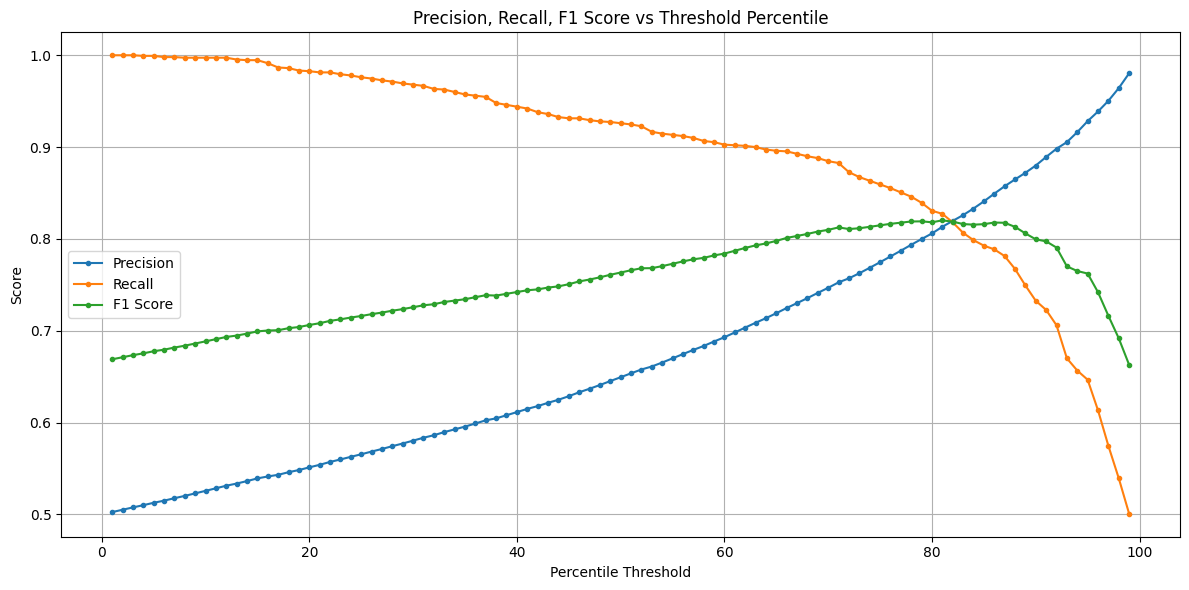

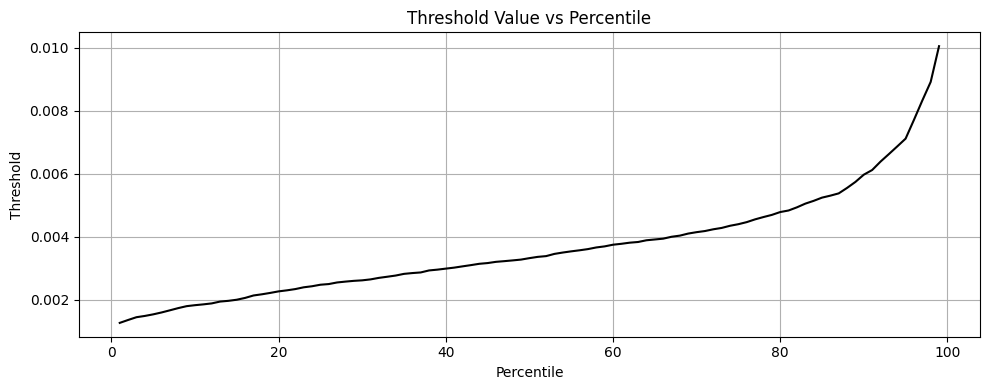

In [ ]:
#@title Threshold Selection with Percentile

# --------------------------
# Dataset & DataLoader
# --------------------------
batch_size = 128
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# --------------------------
# Model Evaluation per Batch
# --------------------------
model.eval()
losses, labels = [], []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        recon, _, _ = model(x)
        batch_loss = torch.mean((recon - x) ** 2, dim=(1, 2, 3))
        losses.append(batch_loss.cpu())
        labels.append(y.cpu())

loss_per_sample = torch.cat(losses)
labels = torch.cat(labels).int()

# --------------------------
# Thresholds from Various Percentiles (1%-99%)
# --------------------------
percentiles = list(range(1, 100))
thresholds = [torch.quantile(loss_per_sample[labels == 0], p / 100) for p in percentiles]

results = []

print("\n=== Percentile-based Evaluation ===")
for p, thresh in zip(percentiles, thresholds):
    preds = (loss_per_sample > thresh).int()
    cm = confusion_matrix(labels, preds)
    precision = precision_score(labels, preds, zero_division=0)
    recall = recall_score(labels, preds, zero_division=0)
    f1 = f1_score(labels, preds, zero_division=0)
    results.append((p, thresh.item(), precision, recall, f1))

    print(f"\n--- Percentile {p}% ---")
    print(f"Threshold : {thresh.item():.6f}")
    print(f"Precision : {precision:.4f}")
    print(f"Recall    : {recall:.4f}")
    print(f"F1 Score  : {f1:.4f}")
    print(f"Confusion Matrix:\n{cm}")

# --------------------------
# Metric vs Percentile Visualization
# --------------------------
percentiles, thresholds, precisions, recalls, f1s = zip(*results)

plt.figure(figsize=(12, 6))
plt.plot(percentiles, precisions, label="Precision", marker='.')
plt.plot(percentiles, recalls, label="Recall", marker='.')
plt.plot(percentiles, f1s, label="F1 Score", marker='.')
plt.xlabel("Percentile Threshold")
plt.ylabel("Score")
plt.title("Precision, Recall, F1 Score vs Threshold Percentile")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --------------------------
# Threshold Value vs Percentile Visualization
# --------------------------
plt.figure(figsize=(10, 4))
plt.plot(percentiles, thresholds, label="Threshold Value", color='black')
plt.xlabel("Percentile")
plt.ylabel("Threshold")
plt.title("Threshold Value vs Percentile")
plt.grid(True)
plt.tight_layout()
plt.show()


Best Threshold: 0.0048001893

=== Evaluation Metrics ===
Confusion Matrix:
[[1230  270]
 [ 272 1228]]
Precision : 0.8198
Recall    : 0.8187
F1-score  : 0.8192
Threshold : 0.0049


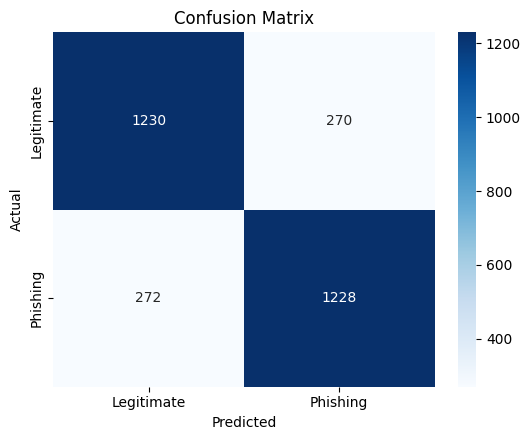

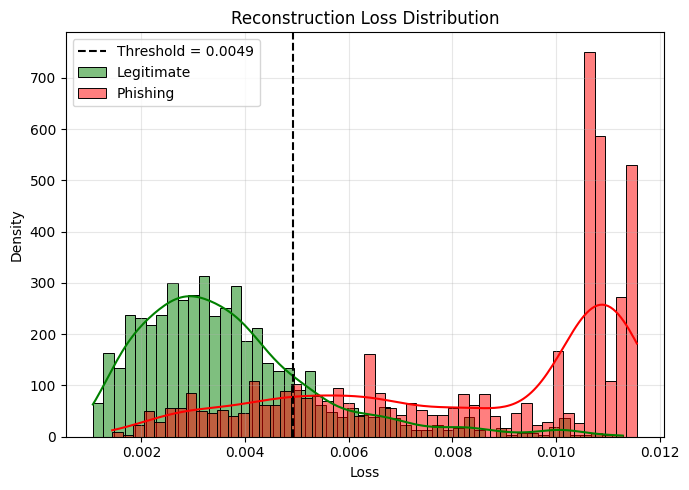

In [ ]:
#@title Model Evaluation per Sample
model.eval()
losses, labels = [], []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        recon, _, _ = model(x)

        # Calculate loss for each sample
        batch_loss = torch.mean((recon - x) ** 2, dim=(1, 2, 3))
        losses.append(batch_loss)
        labels.append(y)

# Convert to tensors
losses = torch.cat(losses)
labels = torch.cat(labels).int().to(device)

# Threshold Selection
threshold = torch.quantile(losses[labels == 0], 0.82)
predictions = (losses > threshold).int()


# Cari threshold optimal
from sklearn.metrics import precision_recall_curve

# Use labels.cpu() as y_true and losses.cpu() as y_scores
precision, recall, thresholds = precision_recall_curve(labels.cpu(), losses.cpu())
f1_scores = 2*precision*recall / (precision+recall)
best_threshold = thresholds[np.argmax(f1_scores)]
print("Best Threshold:", best_threshold)

# Evaluation Metrics
cm = confusion_matrix(labels.cpu(), predictions.cpu())
precision = precision_score(labels.cpu(), predictions.cpu())
recall = recall_score(labels.cpu(), predictions.cpu())
f1 = f1_score(labels.cpu(), predictions.cpu())

# Print results
print("\n=== Evaluation Metrics ===")
print(f"Confusion Matrix:\n{cm}")
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"F1-score  : {f1:.4f}")
print(f"Threshold : {threshold.item():.4f}")

# Plot Confusion Matrix
plt.figure(figsize=(5.5, 4.5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Legitimate', 'Phishing'],
            yticklabels=['Legitimate', 'Phishing'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Plot Distribution of Reconstruction Loss
plt.figure(figsize=(7, 5))
sns.histplot(losses[labels == 0].cpu().numpy(), bins=50, label='Legitimate', color='green', kde=True, stat='density')
sns.histplot(losses[labels == 1].cpu().numpy(), bins=50, label='Phishing', color='red', kde=True, stat='density')
plt.axvline(threshold.item(), color='black', linestyle='--', label=f'Threshold = {threshold.item():.4f}')
plt.title("Reconstruction Loss Distribution")
plt.xlabel("Loss")
plt.ylabel("Density")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

<ipython-input-126-219d17a5b694>:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(info['path']))



Model loaded: /content/drive/MyDrive/Thesis - Undergraduate Ch./Models/Dataset 10000/Training Results/Fixed/vae_cnn_latent4_lr0.001_bs16_optAdam.pth with latent_dim=4
Precision: 0.8199
Recall   : 0.8193
F1-score : 0.8196


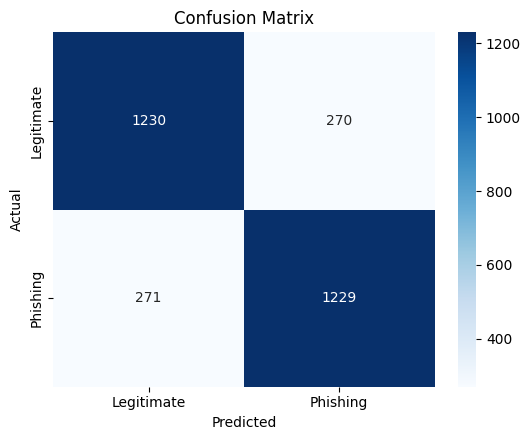

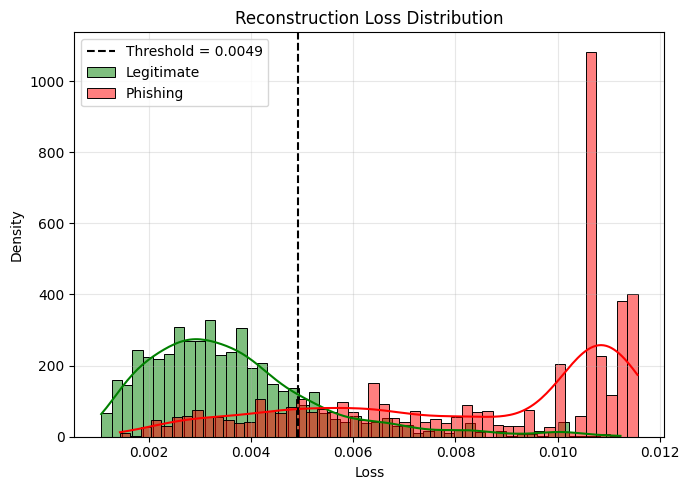

<ipython-input-126-219d17a5b694>:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(info['path']))



Model loaded: /content/drive/MyDrive/Thesis - Undergraduate Ch./Models/Dataset 10000/Training Results/Fixed/vae_cnn_latent4_lr0.001_bs32_optAdam.pth with latent_dim=4
Precision: 0.8193
Recall   : 0.8160
F1-score : 0.8176


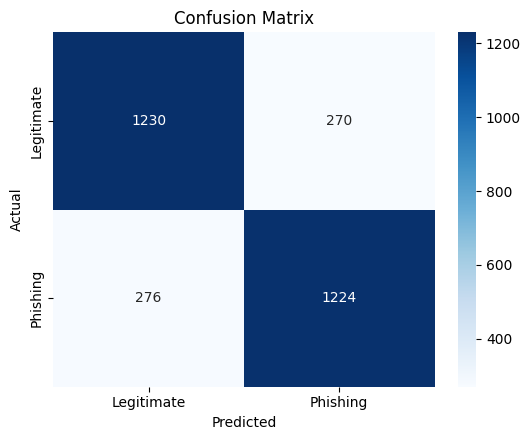

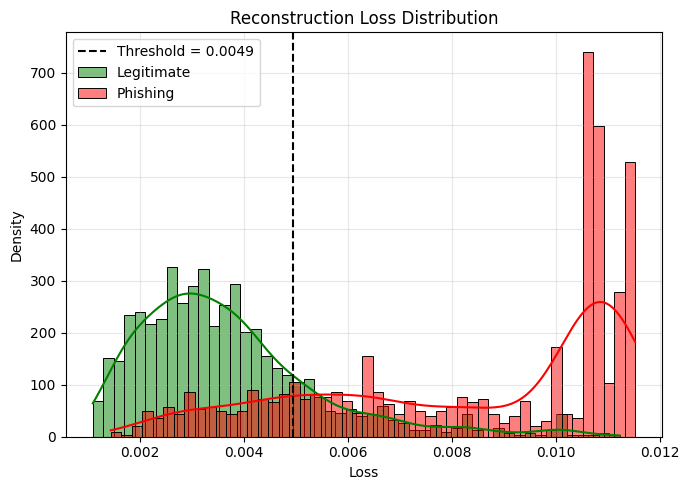

<ipython-input-126-219d17a5b694>:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(info['path']))



Model loaded: /content/drive/MyDrive/Thesis - Undergraduate Ch./Models/Dataset 10000/Training Results/Fixed/vae_cnn_latent8_lr0.001_bs16_optAdam.pth with latent_dim=8
Precision: 0.8198
Recall   : 0.8187
F1-score : 0.8192


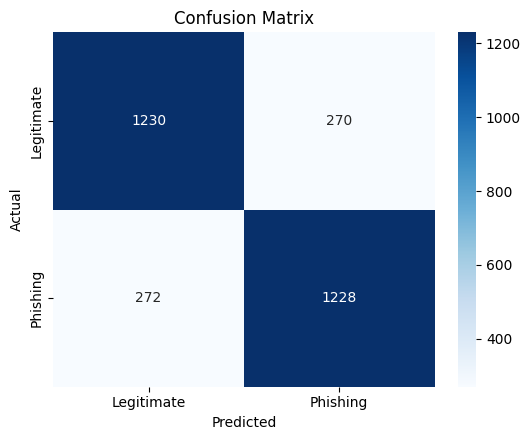

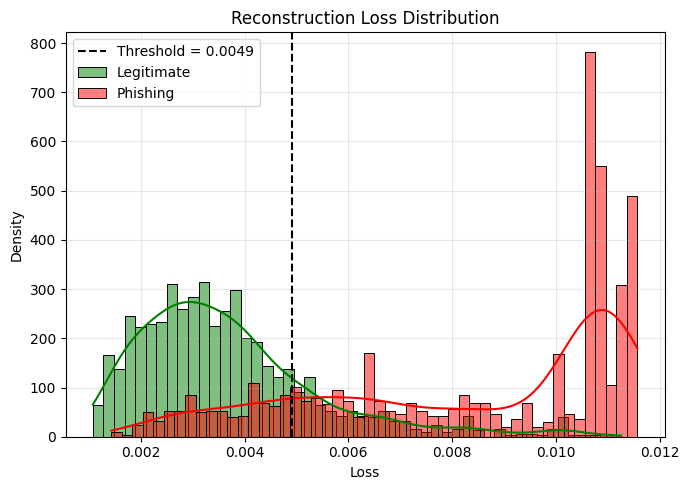

<ipython-input-126-219d17a5b694>:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(info['path']))



Model loaded: /content/drive/MyDrive/Thesis - Undergraduate Ch./Models/Dataset 10000/Training Results/Fixed/vae_cnn_latent8_lr0.001_bs32_optAdam.pth with latent_dim=8
Precision: 0.8200
Recall   : 0.8200
F1-score : 0.8200


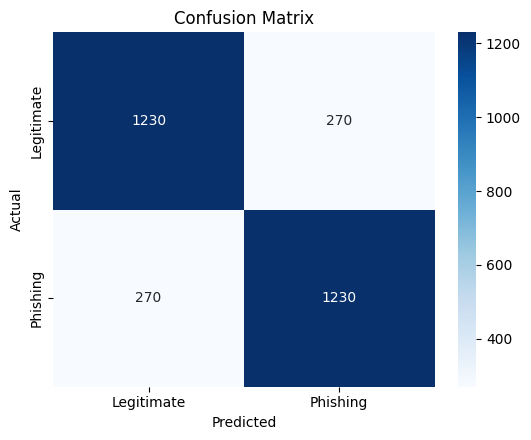

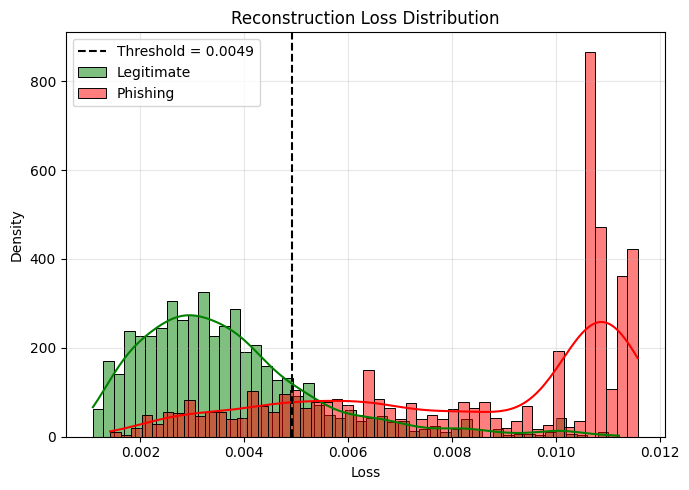

<ipython-input-126-219d17a5b694>:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(info['path']))



Model loaded: /content/drive/MyDrive/Thesis - Undergraduate Ch./Models/Dataset 10000/Training Results/Fixed/vae_cnn_latent16_lr0.001_bs16_optAdam.pth with latent_dim=16
Precision: 0.8193
Recall   : 0.8160
F1-score : 0.8176


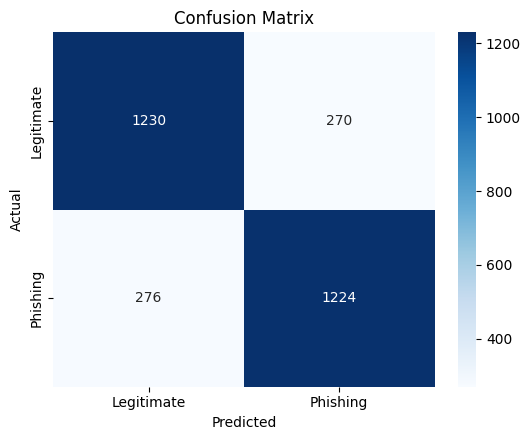

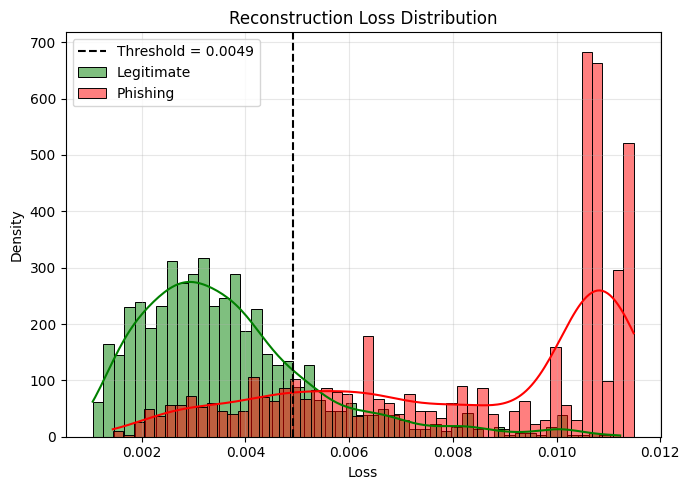

<ipython-input-126-219d17a5b694>:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(info['path']))



Model loaded: /content/drive/MyDrive/Thesis - Undergraduate Ch./Models/Dataset 10000/Training Results/Fixed/vae_cnn_latent16_lr0.001_bs32_optAdam.pth with latent_dim=16
Precision: 0.8198
Recall   : 0.8187
F1-score : 0.8192


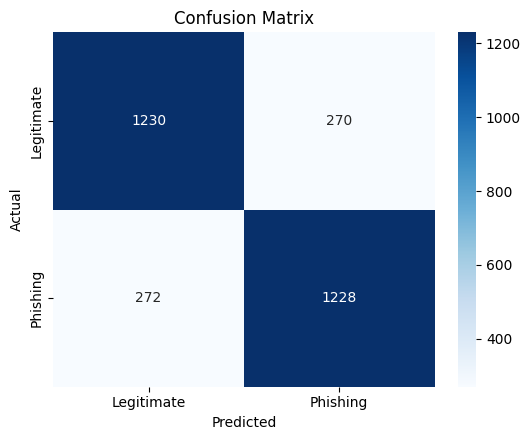

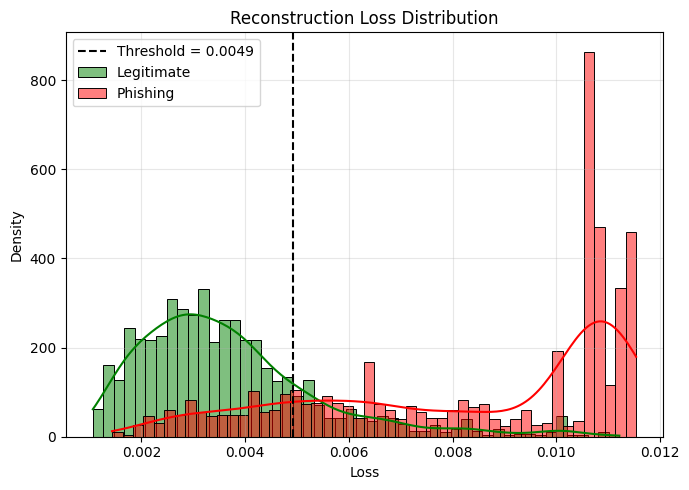


=== Best Model Summary ===
Best model: vae_cnn_latent8_lr0.001_bs32_optAdam.pth, Latent Dim: 8
Precision : 0.8200
Recall    : 0.8200
F1-Score  : 0.8200


In [ ]:
#@title Model Evaluation per Batch

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define models and their corresponding latent dimensions
models_info = [
    {'path': '/content/drive/MyDrive/Thesis - Undergraduate Ch./Models/Dataset 10000/Training Results/Fixed/vae_cnn_latent4_lr0.001_bs16_optAdam.pth', 'latent_dim': 4},
    {'path': '/content/drive/MyDrive/Thesis - Undergraduate Ch./Models/Dataset 10000/Training Results/Fixed/vae_cnn_latent4_lr0.001_bs32_optAdam.pth', 'latent_dim': 4},
    {'path': '/content/drive/MyDrive/Thesis - Undergraduate Ch./Models/Dataset 10000/Training Results/Fixed/vae_cnn_latent8_lr0.001_bs16_optAdam.pth', 'latent_dim': 8},
    {'path': '/content/drive/MyDrive/Thesis - Undergraduate Ch./Models/Dataset 10000/Training Results/Fixed/vae_cnn_latent8_lr0.001_bs32_optAdam.pth', 'latent_dim': 8},
    {'path': '/content/drive/MyDrive/Thesis - Undergraduate Ch./Models/Dataset 10000/Training Results/Fixed/vae_cnn_latent16_lr0.001_bs16_optAdam.pth', 'latent_dim': 16},
    {'path': '/content/drive/MyDrive/Thesis - Undergraduate Ch./Models/Dataset 10000/Training Results/Fixed/vae_cnn_latent16_lr0.001_bs32_optAdam.pth', 'latent_dim': 16},
]

# Initialize tracking variables
best_f1 = 0
best_model_info = {}

# Loop through all models
for info in models_info:
    # Load model
    model = VAE_CNN(latent_dim=info['latent_dim']).to(device)
    model.load_state_dict(torch.load(info['path']))
    model.eval()
    print(f"\nModel loaded: {info['path']} with latent_dim={info['latent_dim']}")

    # Evaluate model
    losses, labels = [], []
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            recon, _, _ = model(x)
            batch_loss = torch.mean((recon - x) ** 2, dim=(1, 2, 3))
            losses.append(batch_loss)
            labels.append(y)

    losses = torch.cat(losses)
    labels = torch.cat(labels).int().to(device)

    # Threshold based on quantile
    threshold = torch.quantile(losses[labels == 0], 0.82)
    predictions = (losses > threshold).int()

    # Calculate metrics
    cm = confusion_matrix(labels.cpu(), predictions.cpu())
    precision_val = precision_score(labels.cpu(), predictions.cpu(), zero_division=0)
    recall_val = recall_score(labels.cpu(), predictions.cpu(), zero_division=0)
    f1_val = f1_score(labels.cpu(), predictions.cpu(), zero_division=0)

    print(f"Precision: {precision_val:.4f}")
    print(f"Recall   : {recall_val:.4f}")
    print(f"F1-score : {f1_val:.4f}")

    # Plot Confusion Matrix
    plt.figure(figsize=(5.5, 4.5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Legitimate', 'Phishing'],
                yticklabels=['Legitimate', 'Phishing'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

    # Plot Reconstruction Loss Distribution
    plt.figure(figsize=(7, 5))
    sns.histplot(losses[labels == 0].cpu().numpy(), bins=50, label='Legitimate', color='green', kde=True, stat='density')
    sns.histplot(losses[labels == 1].cpu().numpy(), bins=50, label='Phishing', color='red', kde=True, stat='density')
    plt.axvline(threshold.item(), color='black', linestyle='--', label=f'Threshold = {threshold.item():.4f}')
    plt.title("Reconstruction Loss Distribution")
    plt.xlabel("Loss")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Track best model
    if f1_val > best_f1:
        best_f1 = f1_val
        best_model_info = {
            'path': info['path'],
            'latent_dim': info['latent_dim'],
            'precision': precision_val,
            'recall': recall_val,
            'f1_score': f1_val
        }

# Print the Best Model Summary
print("\n=== Best Model Summary ===")
print(f"Best model: {best_model_info['path'].split('/')[-1]}, Latent Dim: {best_model_info['latent_dim']}")
print(f"Precision : {best_model_info['precision']:.4f}")
print(f"Recall    : {best_model_info['recall']:.4f}")
print(f"F1-Score  : {best_model_info['f1_score']:.4f}")


7. Save the Best Model

In [ ]:
# Save the best model file
import shutil

# Path target for saving the file
best_model_save_path = '/content/drive/MyDrive/Thesis - Undergraduate Ch./Models/Dataset 10000/Training Results/Fixed/Best_Model.pth'

# Copy the best model
shutil.copy(best_model_info['path'], best_model_save_path)

print(f"Best model has been saved to: {best_model_save_path}")

Best model has been saved to: /content/drive/MyDrive/Thesis - Undergraduate Ch./Models/Dataset 10000/Training Results/Fixed/Best_Model.pth


8. Model Testing with New Data

In [ ]:
# Load char_to_idx
with open('/content/drive/MyDrive/Thesis - Undergraduate Ch./Preprocessing/vocabulary_tested.json') as f:
    char_to_idx = json.load(f)
char_to_idx = {k: int(v) for k, v in char_to_idx.items()}

vocab_size = len(char_to_idx) + 1
max_len = 100
print("Vocab size:", vocab_size)

# Load Model
model = VAE_CNN(latent_dim=8)
model.load_state_dict(torch.load(
    '/content/drive/MyDrive/Thesis - Undergraduate Ch./Models/Dataset 10000/Training Results/Fixed/Best_Model.pth',
    map_location=device))
model.to(device)
model.eval()

# Preprocess
def preprocess_url(url, char_to_idx, max_len=100, vocab_size=100):
    encoded = np.zeros((max_len, vocab_size), dtype=np.float32)
    for i, ch in enumerate(url[:max_len]):
        if ch in char_to_idx:
            encoded[i, char_to_idx[ch]] = 1.0
    return torch.tensor(encoded).unsqueeze(0).unsqueeze(0).to(device)

# Test URL
new_url = "https://www.uniwisp.co.za/wp-includes/wlwmanifest.xml"
url_tensor = preprocess_url(new_url, char_to_idx, max_len=max_len, vocab_size=vocab_size)

# Predict + Timing
start_time = time.time()

with torch.no_grad():
    reconstructed, _, _ = model(url_tensor)
    loss = torch.mean((reconstructed - url_tensor) ** 2).item()

end_time = time.time()

# Decision
if loss > threshold:
    print(f"PHISHING (Loss: {loss:.4f})")
else:
    print(f"LEGITIMATE (Loss: {loss:.4f})")

# Display Inference Time
duration = (end_time - start_time) * 1000
print(f"Detection Time: {duration:.2f} ms")


Vocab size: 87
LEGITIMATE (Loss: 0.0031)
Detection Time: 16.10 ms


<ipython-input-129-21b32263e8e4>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(
